In [97]:
import pandas as pd
import numpy as np
import missingno as msno
from matplotlib import pyplot as plt
import sys
sys.path.insert(1, '../Scripts')
from funciones import simbologia, graficar_versus_core

## Load data


In [85]:
Data = pd.read_excel("../Data/TephraDataBase.xlsx")
Data = Data.replace('-',np.nan);Data = Data.replace('not determined',np.nan);Data = Data.replace('Not analyzed',np.nan);Data = Data.replace('Over range',np.nan);Data = Data.replace('bdl',np.nan);Data = Data.replace('<1',np.nan);Data = Data.replace('<4',np.nan);Data = Data.replace('<6',np.nan);Data = Data.replace('<5',np.nan);Data = Data.replace('<10',np.nan);Data = Data.replace('<0.1',np.nan)
Data = Data.drop(['SampleID','SamplePoint','2SE','87Sr/86Sr','TécnicaDeMedición','MaterialMedido','Referencia','Magnitud','TipoDeSección','Latitud','Longitud','CódigoLaboratorioRadiocarbono','Comentarios','Mapa?','Flag','DescripciónFlag','ErrorEdad'], axis=1)
Data = Data[Data.Volcán != 'Unknown']

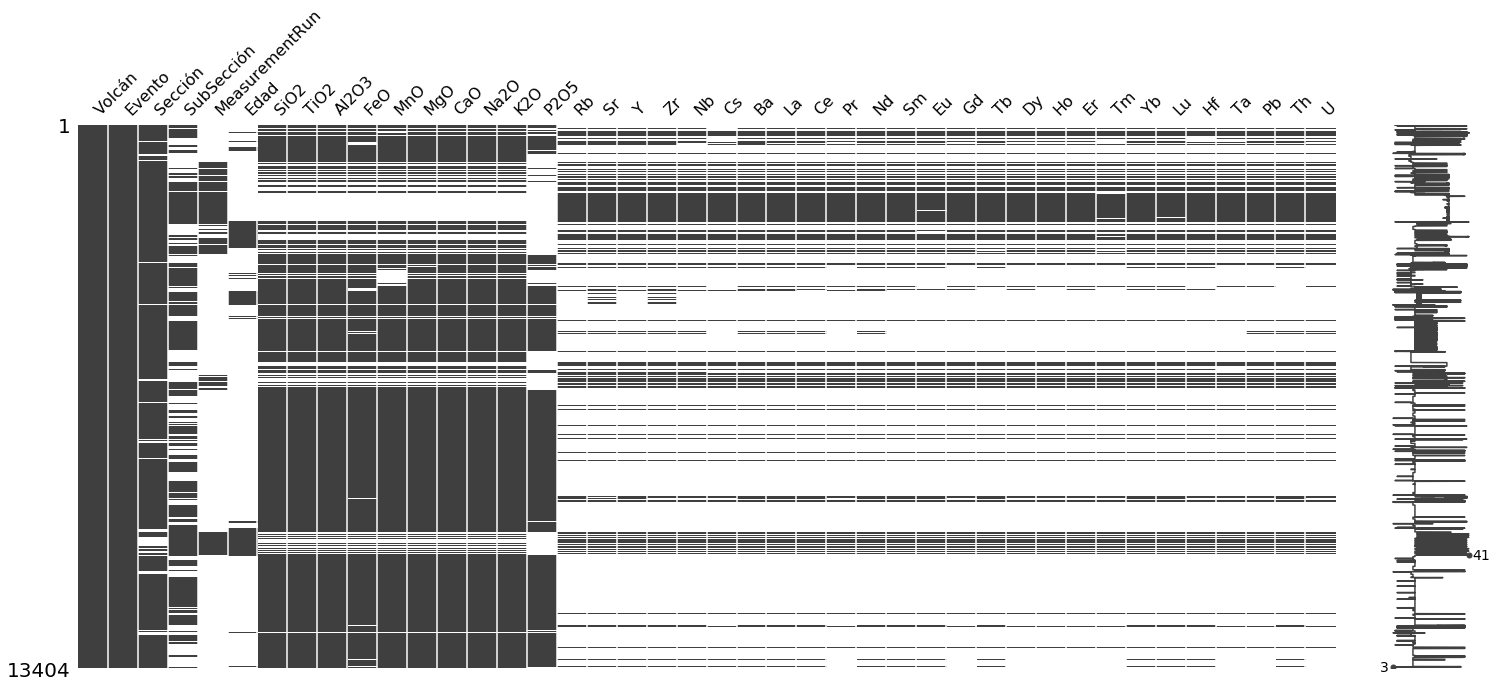

In [3]:
msno.matrix(Data)

Volcán 0
SiO2 2311
TiO2 2311
K2O 2311


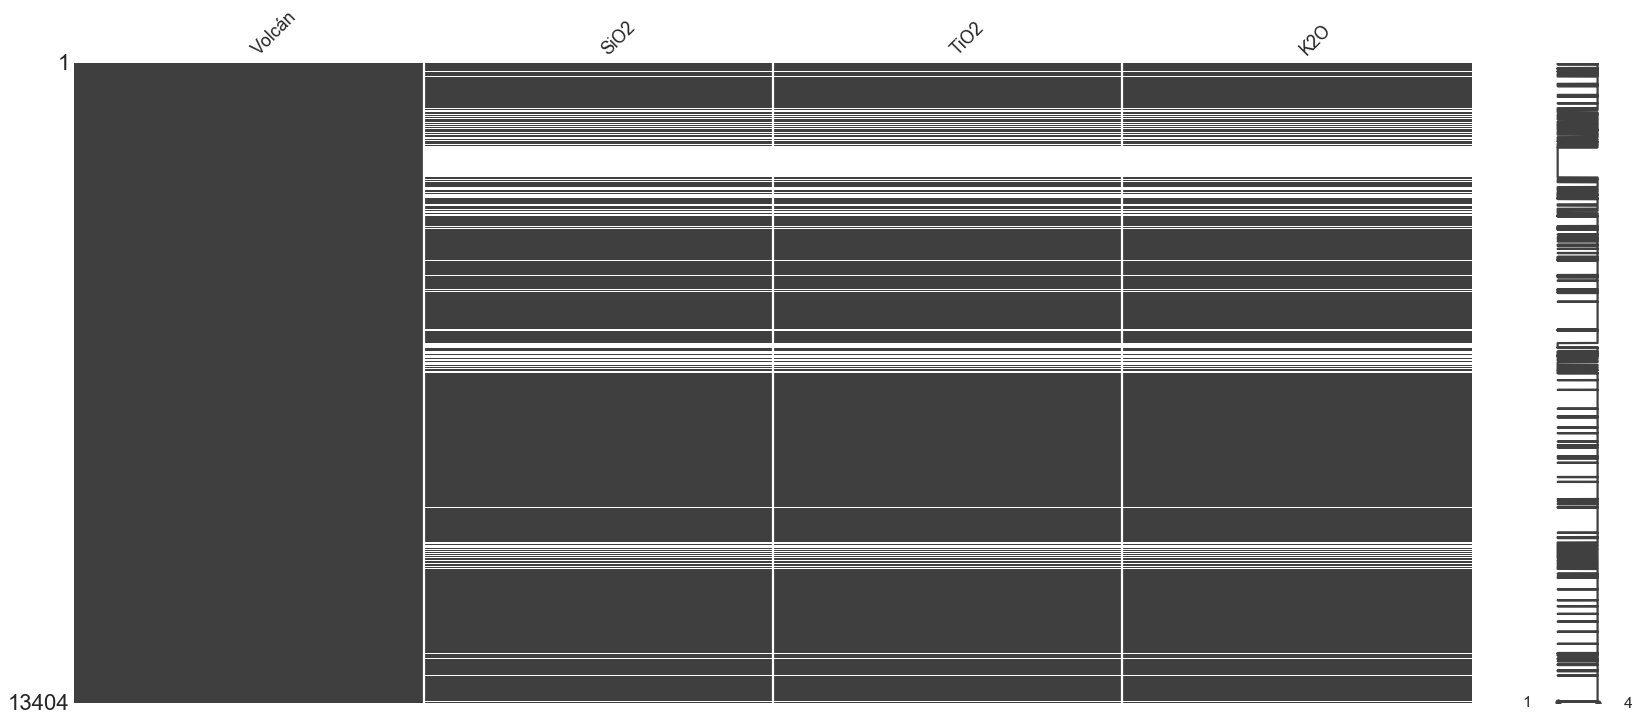

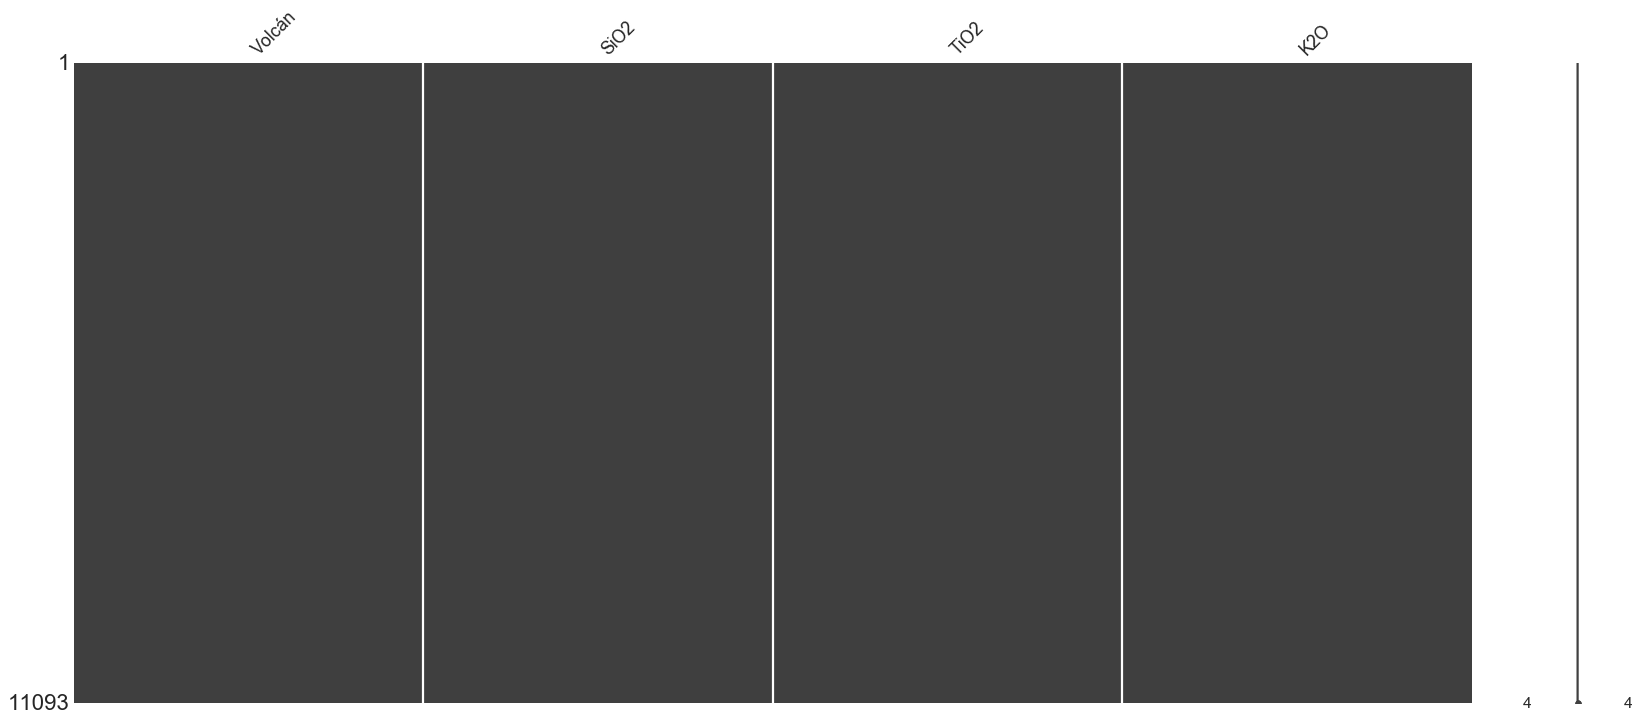

In [86]:
Data = Data[['Volcán','SiO2','TiO2','K2O']]
#Data = Data[['Volcán','Evento','SiO2','TiO2','MgO','CaO','FeO','Al2O3','P2O5','K2O','Rb','Sr','Zr','Nb','Cs','Ba','La','Yb','Ta','Pb']]

for i in Data.columns:
    print(i,Data[i].isna().sum())
    
msno.matrix(Data)
Data = Data.dropna(how='any')
msno.matrix(Data)

In [5]:
import pandas_profiling
report = Data.profile_report()
report.to_file('profile_report_nb.html')

In [87]:
volcaneS = Data.Volcán.value_counts().index.tolist()
i=0
counts = Data.Volcán.value_counts()
for volcan in volcaneS:
    if counts[i] < 10:
        Data = Data[Data.Volcán != volcan]
        print('Volcán {} rejected for having less than 10 samples'.format(volcan))
        print(" ")
    i = i+1
    
print(Data.Volcán.value_counts())

Volcán Huequi rejected for having less than 10 samples
 
Volcán Cay rejected for having less than 10 samples
 
Volcán Corcovado rejected for having less than 10 samples
 
Volcán Yanteles rejected for having less than 10 samples
 
Mocho-Choshuenco           2632
Puyehue-Cordón Caulle      1531
Llaima                     1426
Quetrupillán               1182
Chaitén                    1101
Villarrica                  882
Hudson                      559
Melimoyu                    342
Huanquihue Group            176
Michinmahuida               171
Carrán-Los Venados          155
Calbuco                     140
Caburga-Huelemolle          134
Burney                      116
Antillanca - Casablanca      99
Lanín                        90
Sollipulli                   70
Osorno                       56
Mentolat                     45
Puyehue                      42
Reclus                       41
Apagado                      30
Yate                         27
Subsidiary Vcha dome         21
Ho

 
SiO2


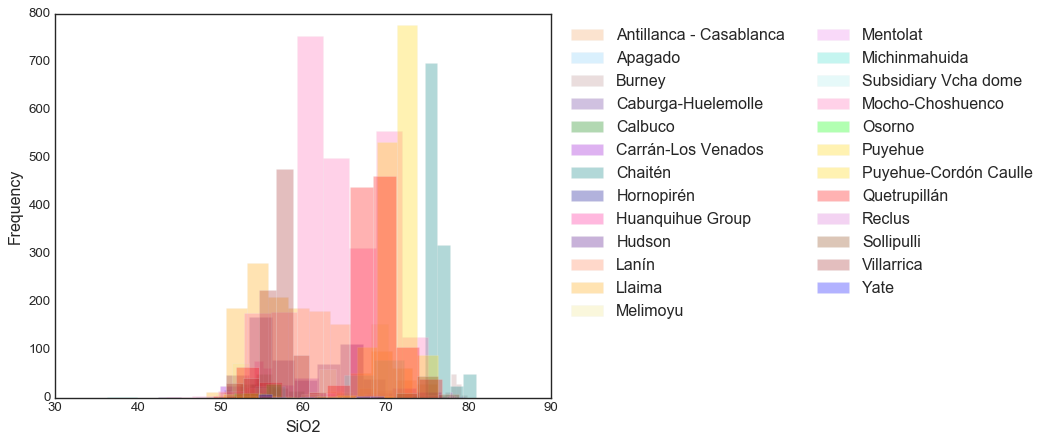

 
TiO2


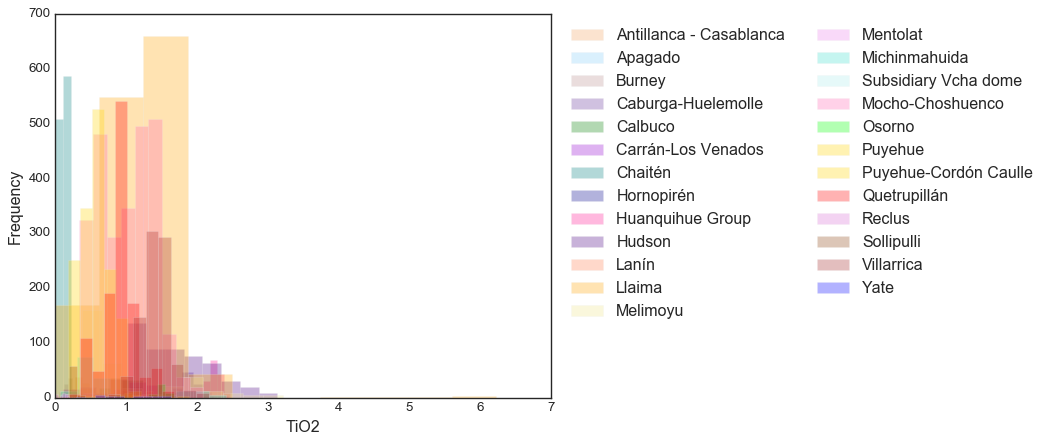

 
K2O


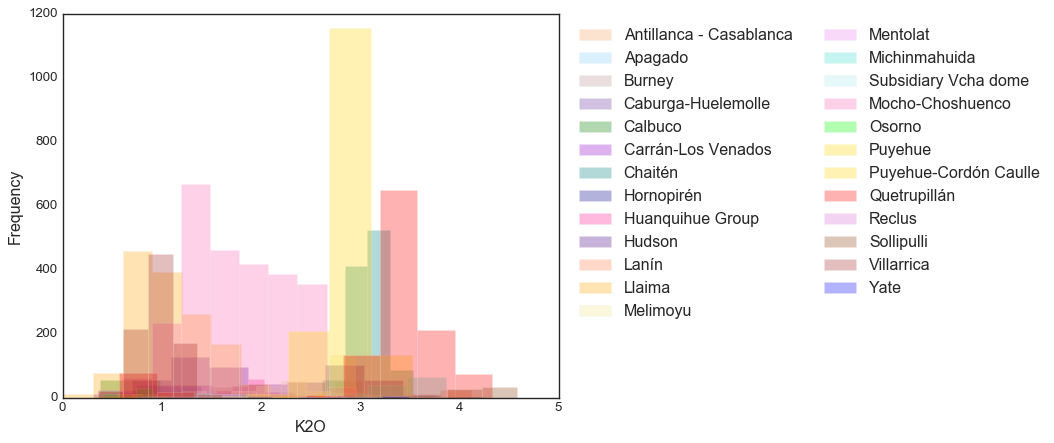

In [100]:
#drop non numerical features
volcanes = Data['Volcán'].unique()

for elemento in Data.columns:

    if (elemento != 'Volcán')&(elemento != 'Evento'):  
        print(" ")
        print('\033[1m'+ elemento + '\033[0m')
        for i in volcanes:
            coloR, Marker  = simbologia(i,'Unknown')
            Data_volcan =Data[Data['Volcán']==i]
            if pd.isnull(Data_volcan[elemento]).all():
                print('Volcán without information {}'.format(i))              
            else:
                plt.hist(Data_volcan[elemento] ,label= i, color = coloR, alpha= 0.3,range=(np.nanmin(Data_volcan[elemento]), np.nanmax(Data_volcan[elemento])))  
    
        plt.gca().set(xlabel=elemento,ylabel='Frequency')
        plt.legend(bbox_to_anchor=(2,1),ncol=2)
        plt.show()      

## Explore distribution by volcano

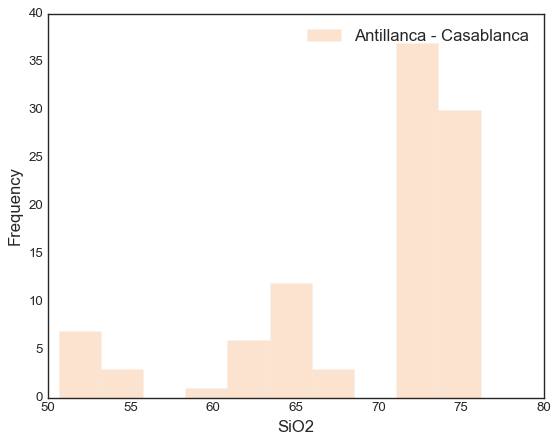

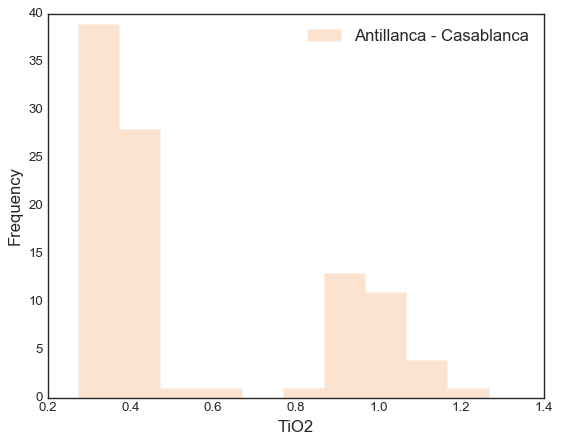

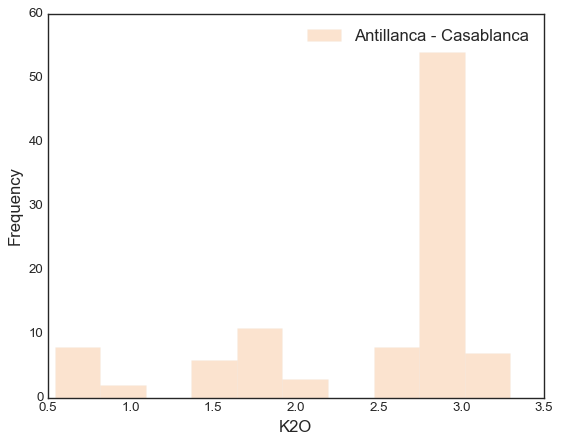

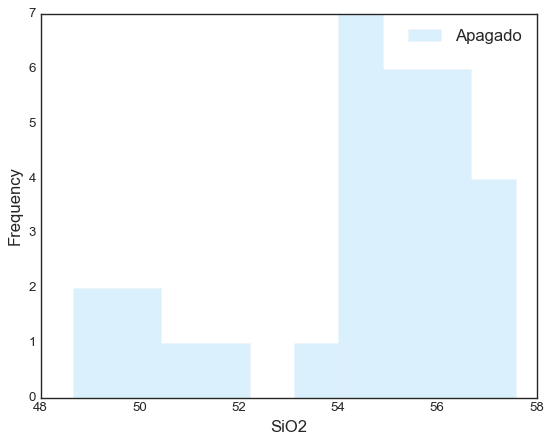

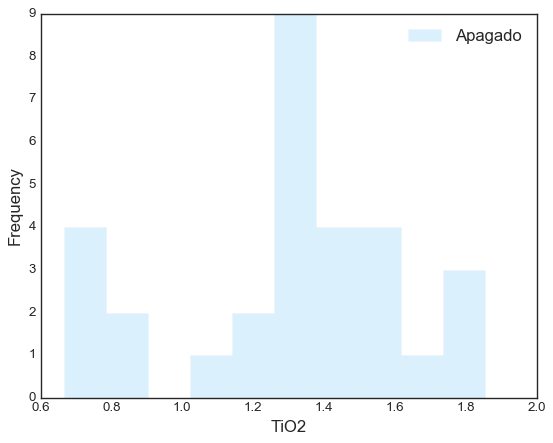

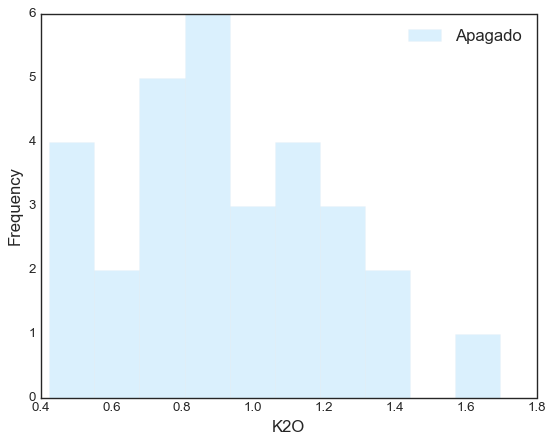

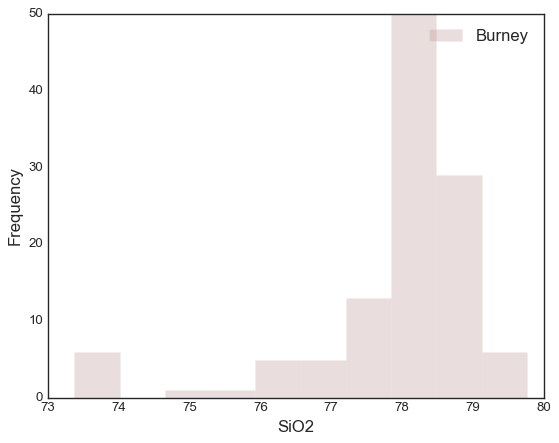

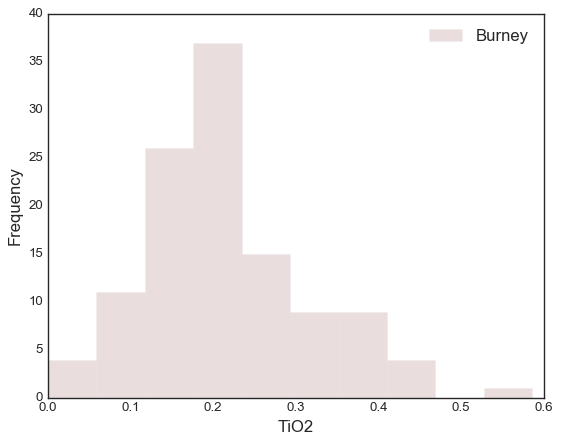

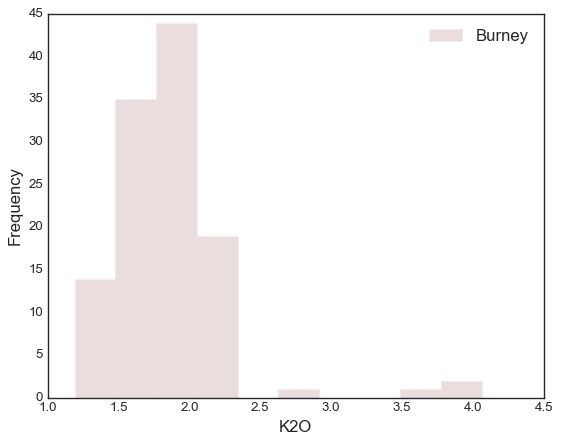

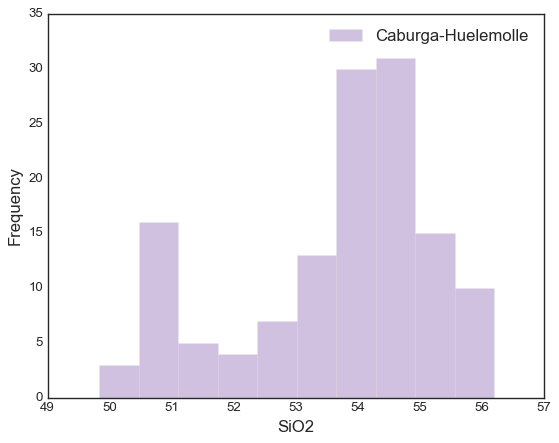

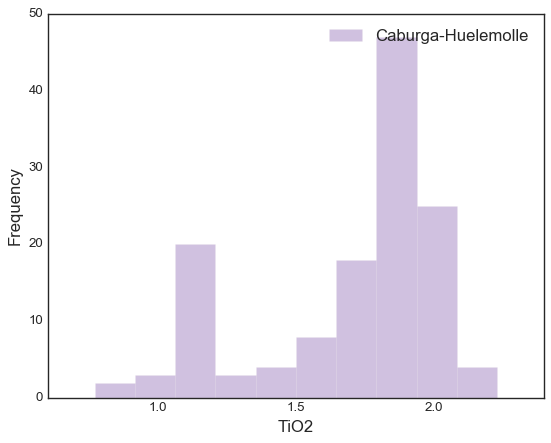

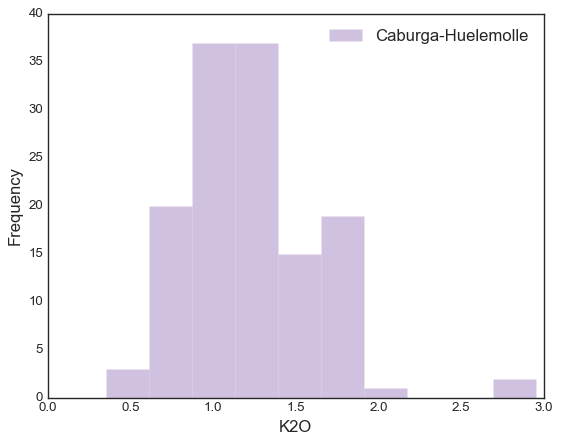

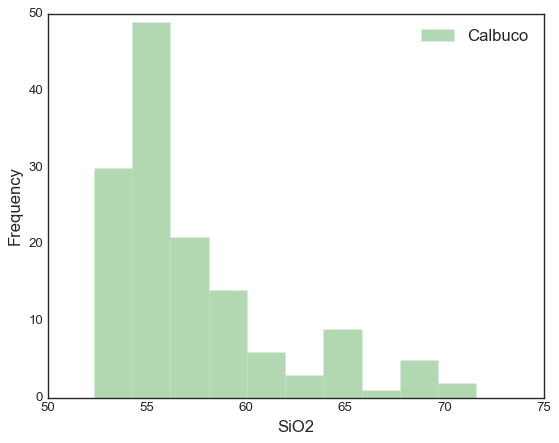

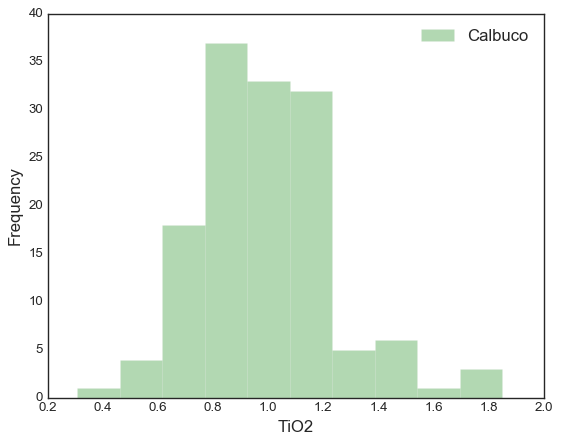

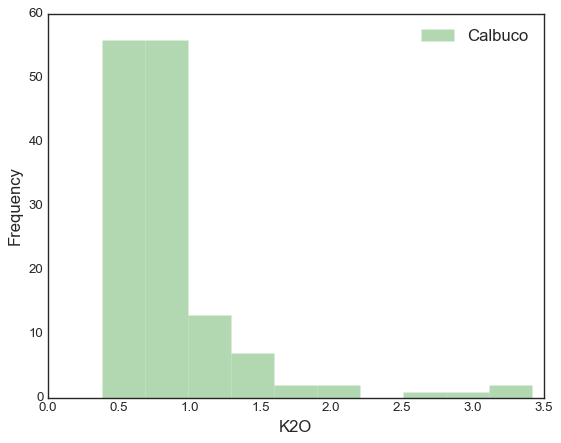

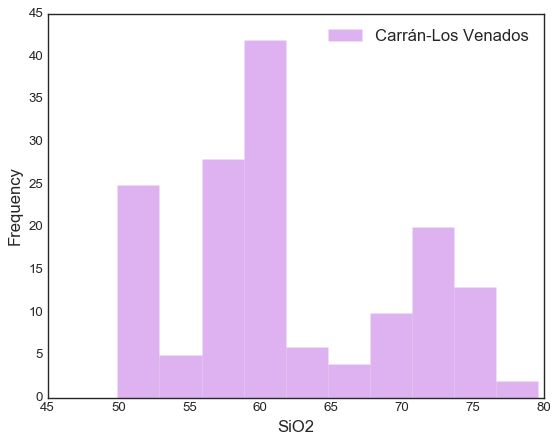

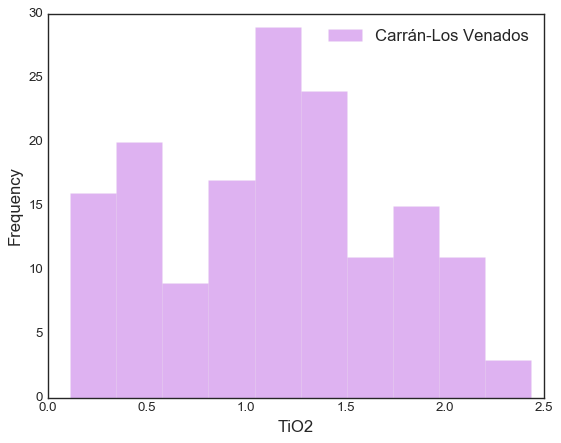

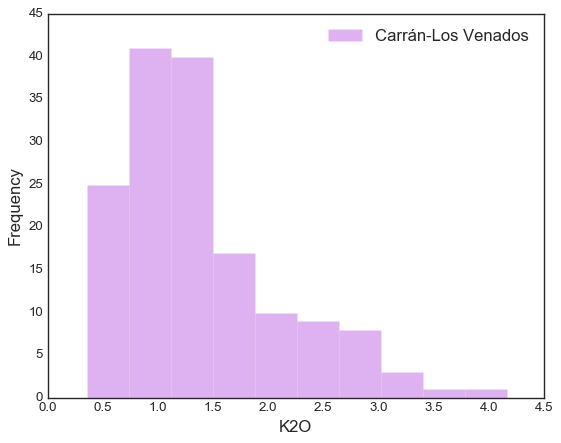

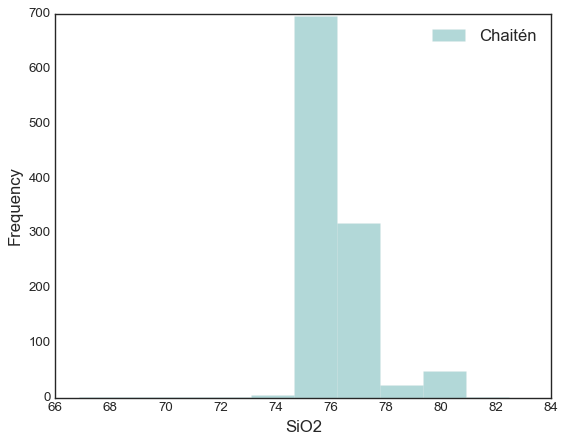

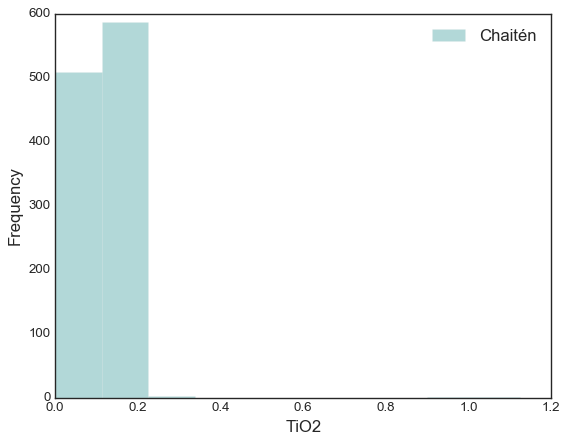

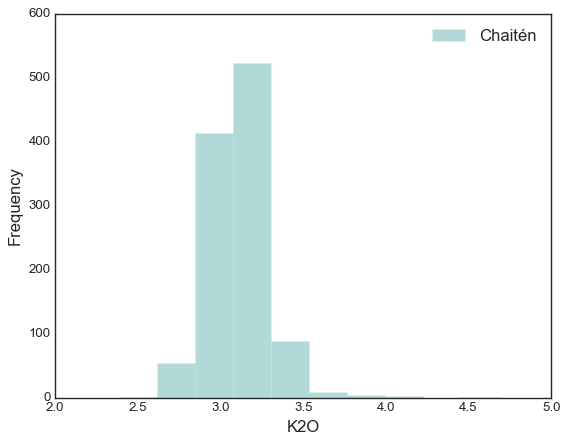

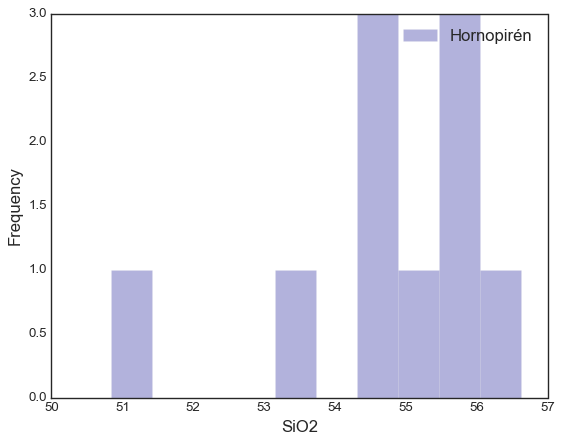

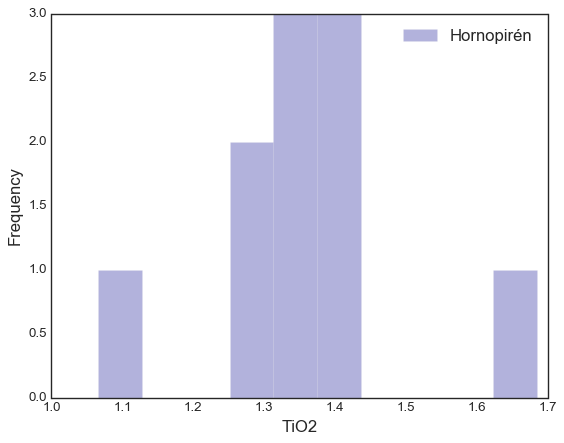

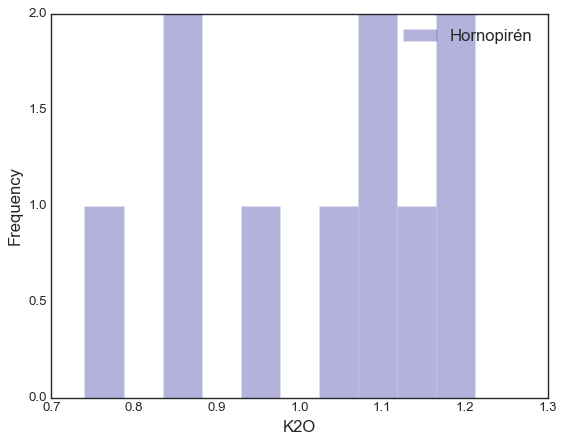

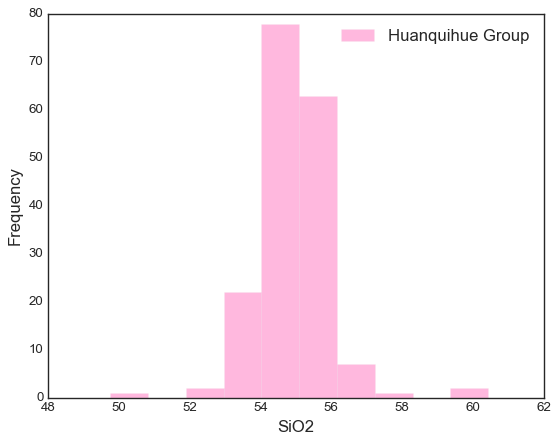

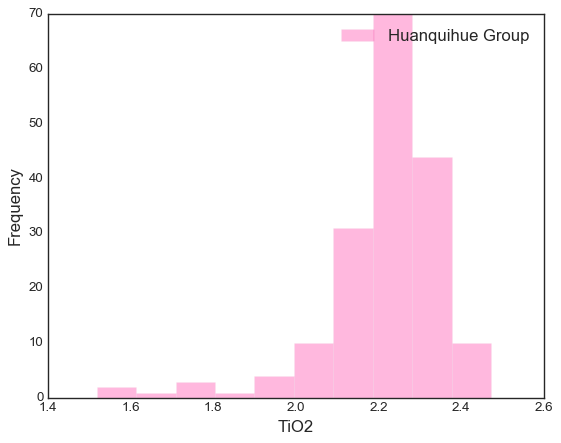

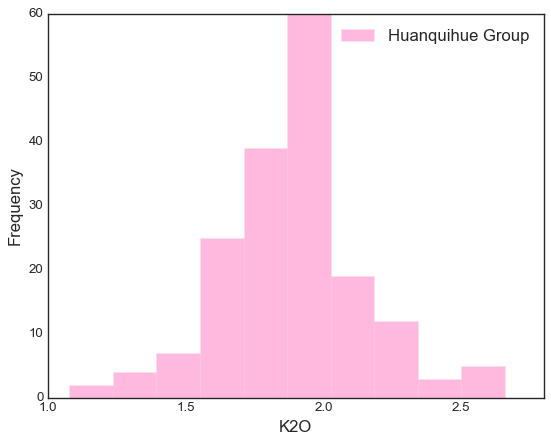

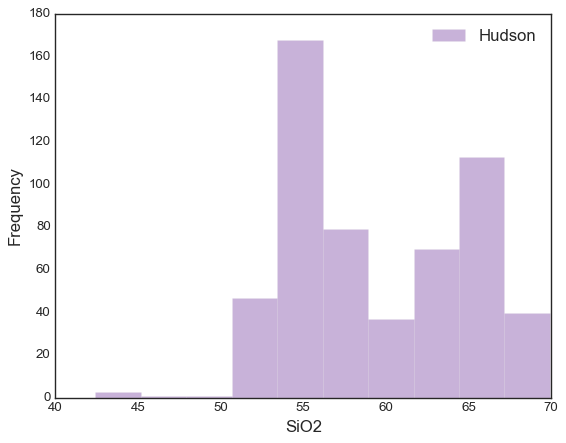

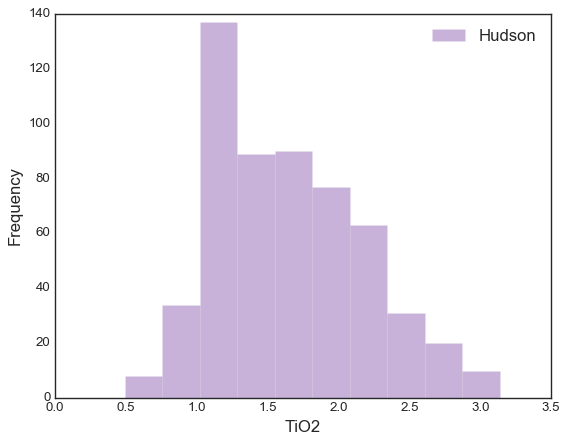

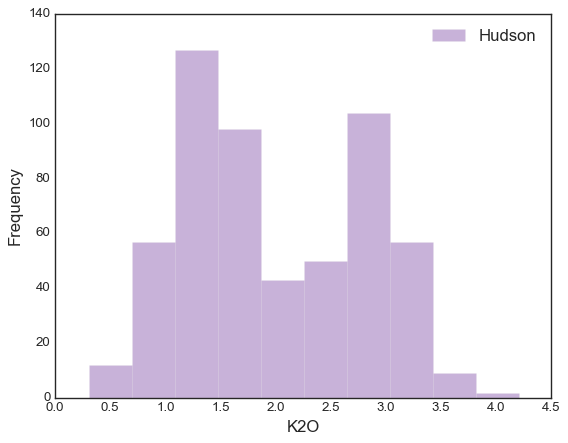

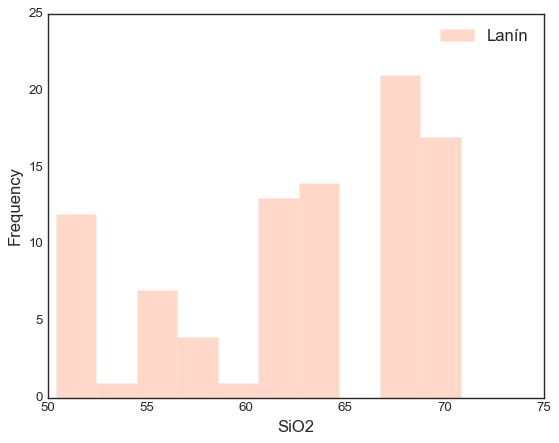

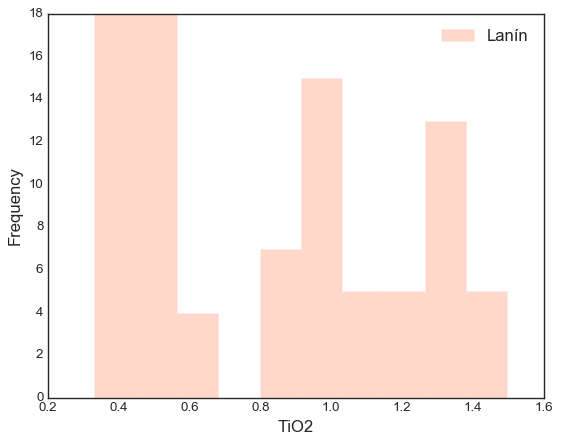

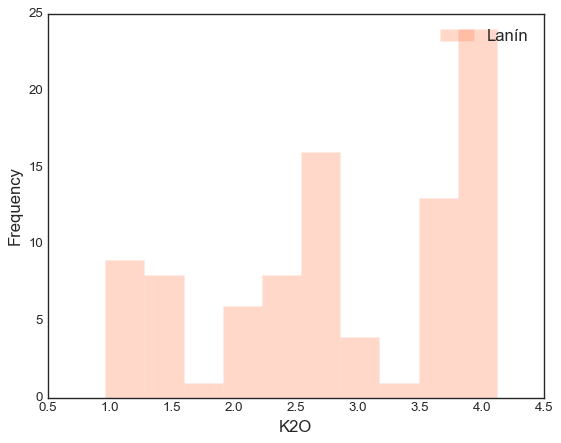

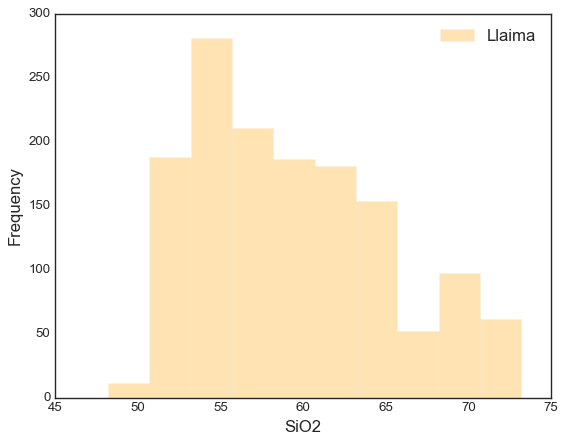

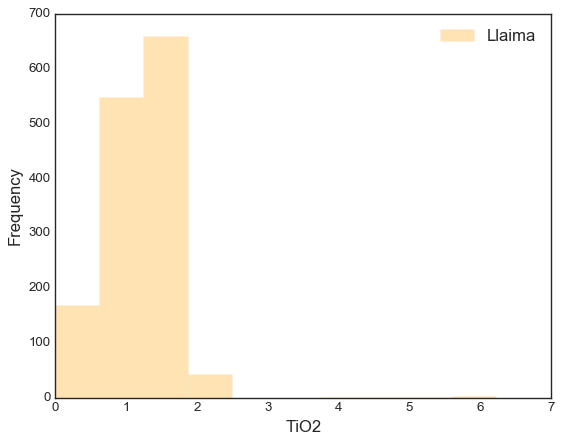

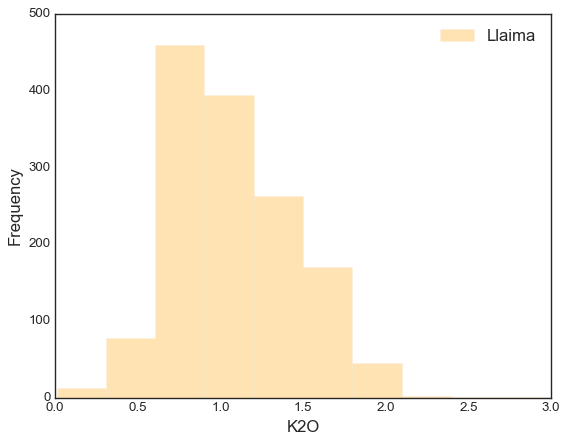

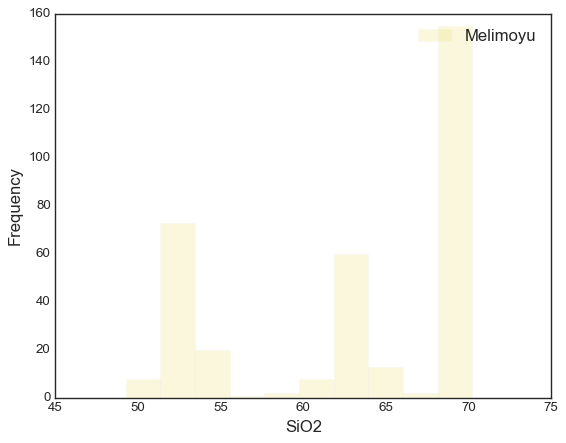

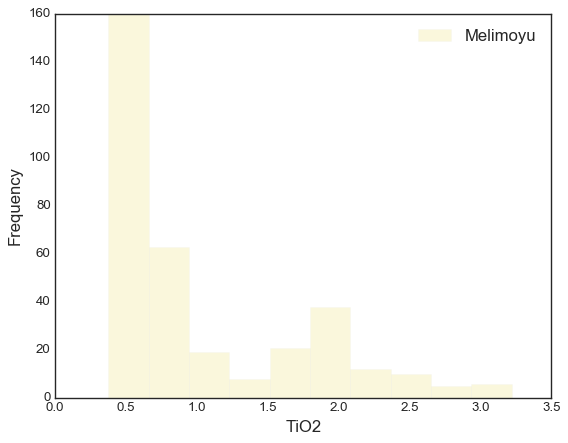

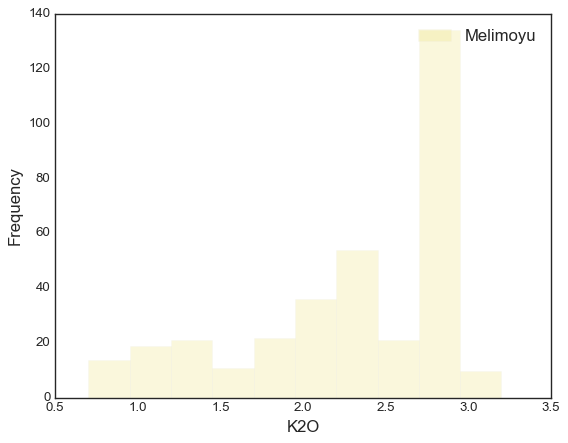

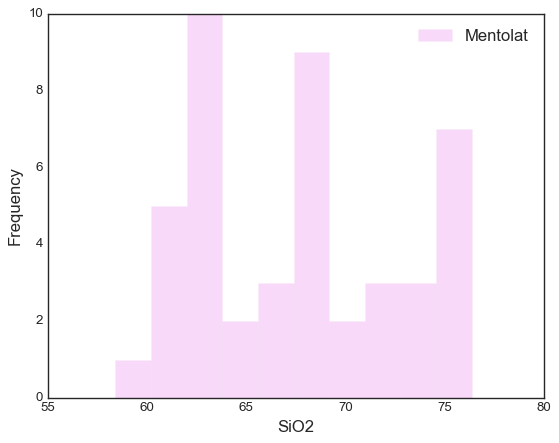

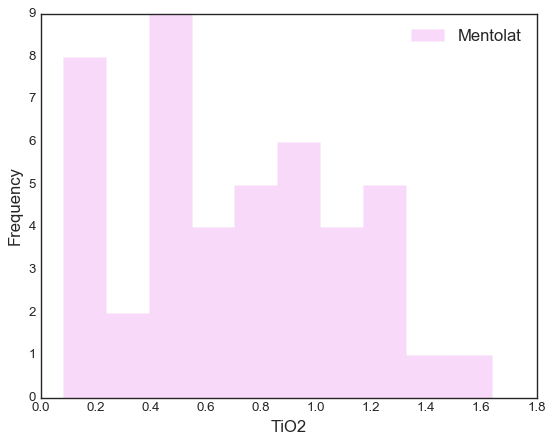

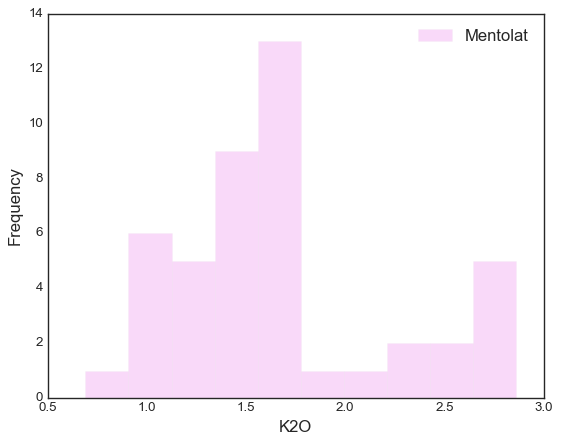

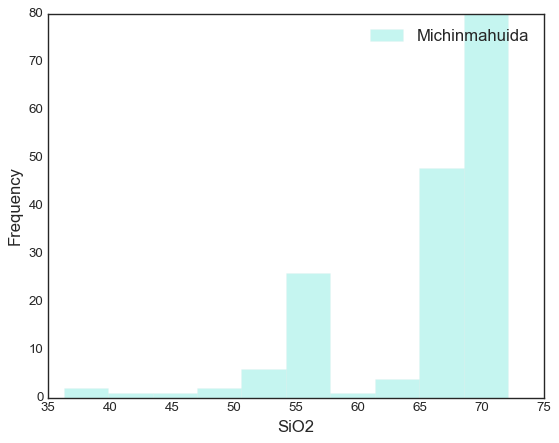

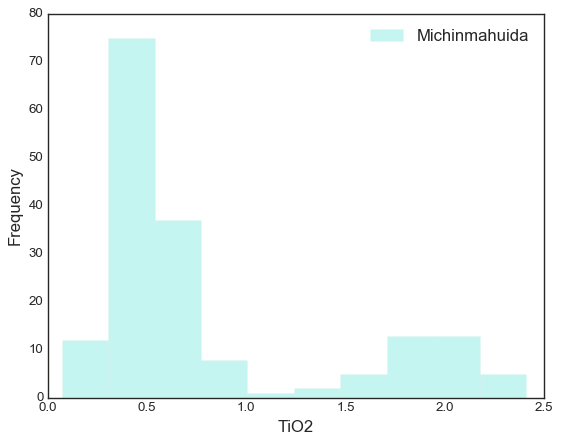

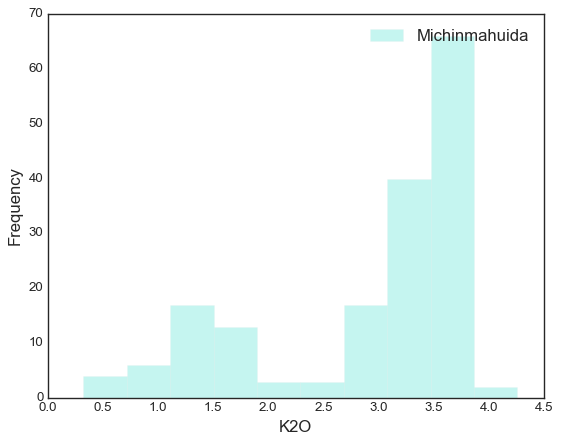

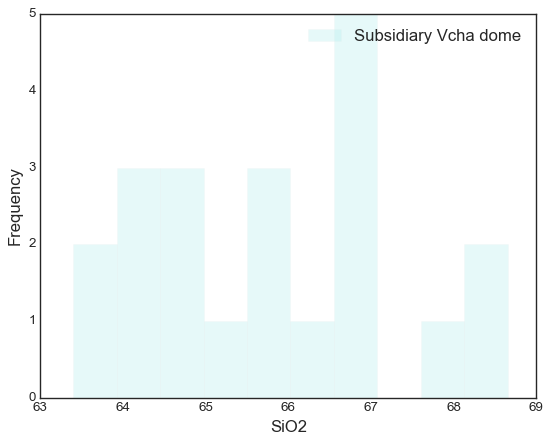

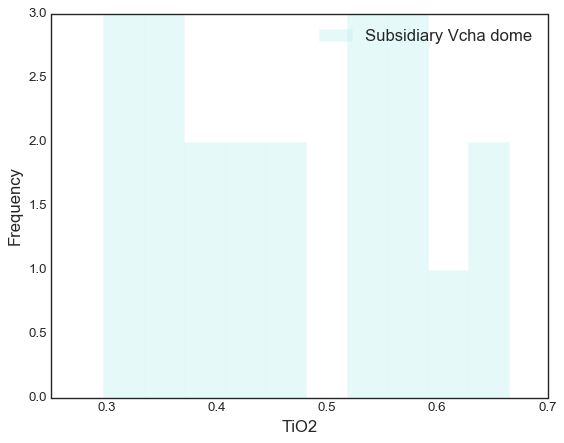

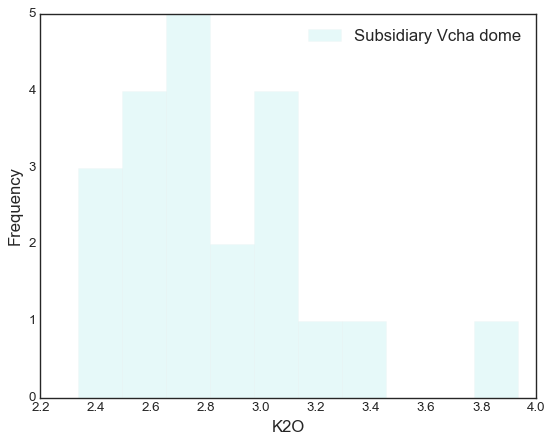

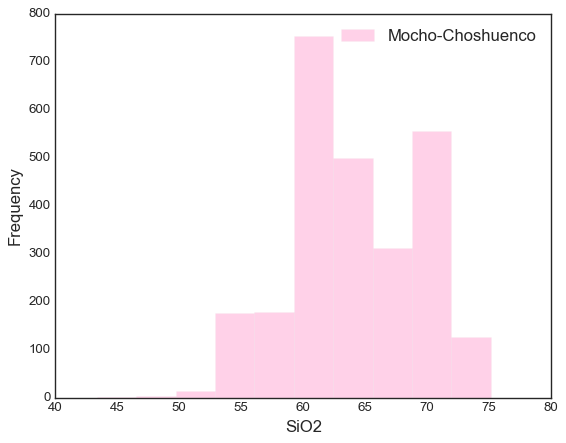

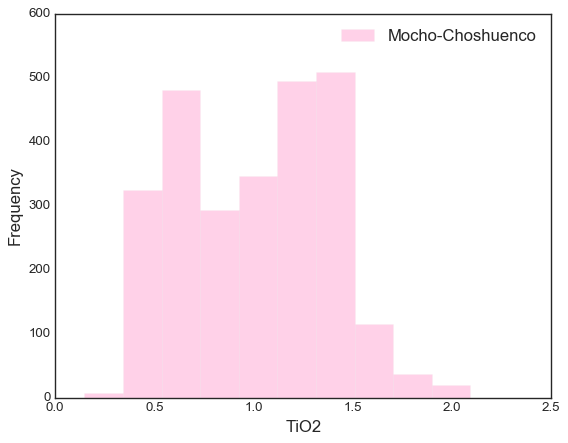

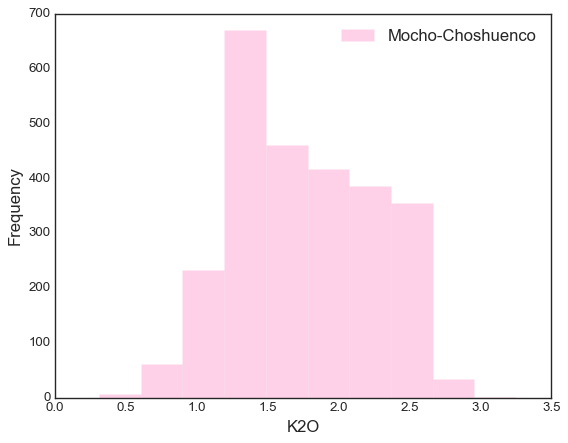

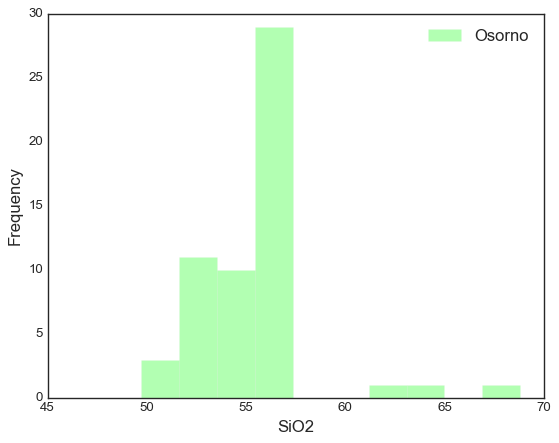

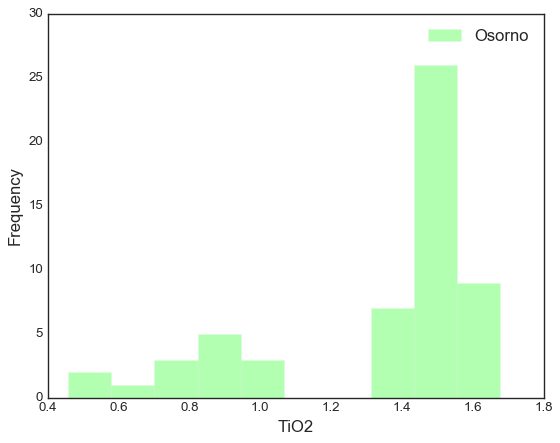

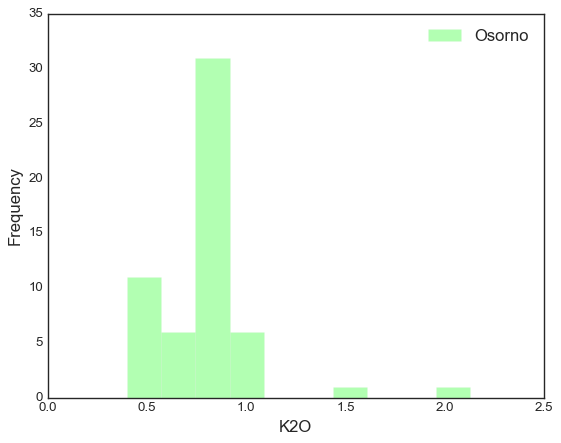

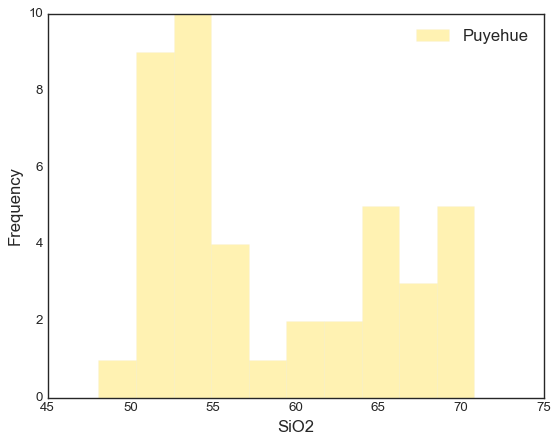

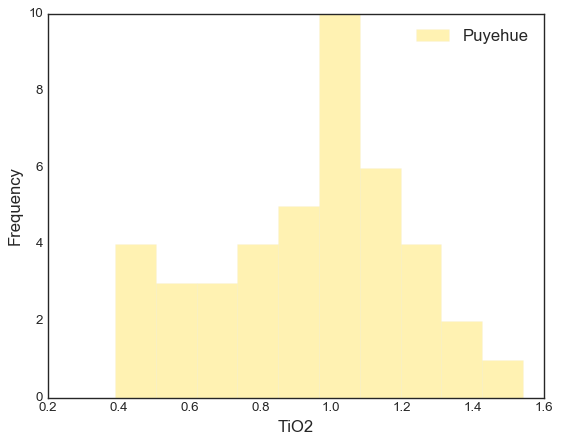

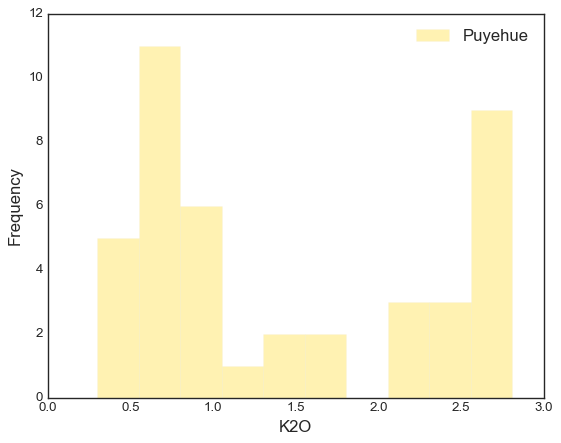

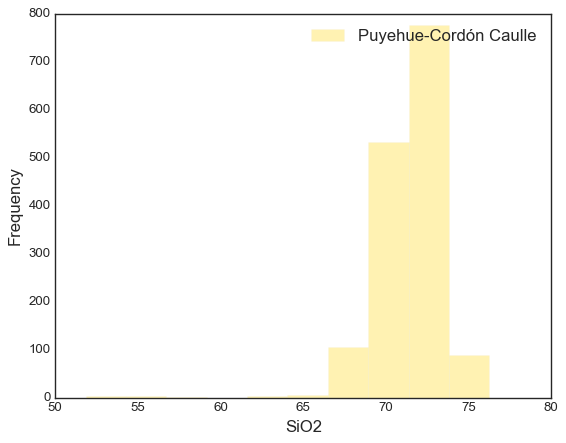

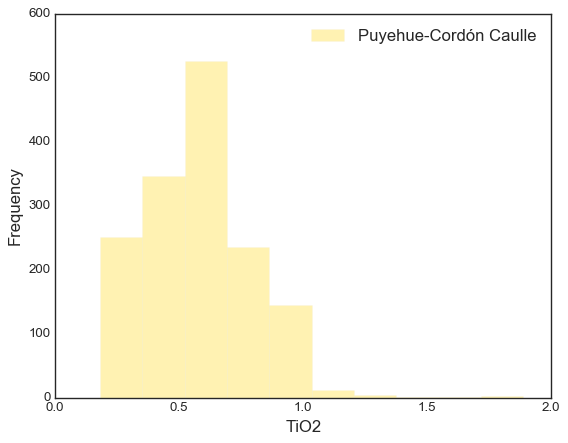

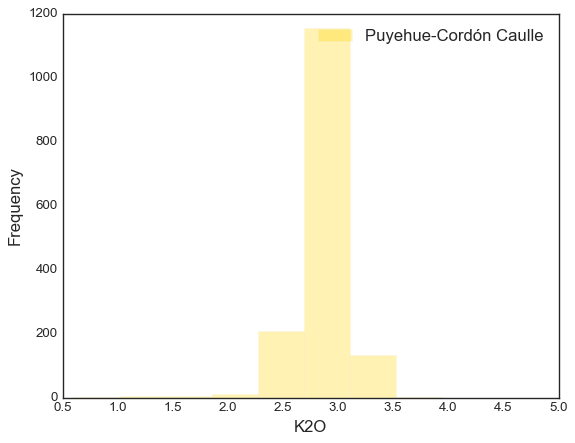

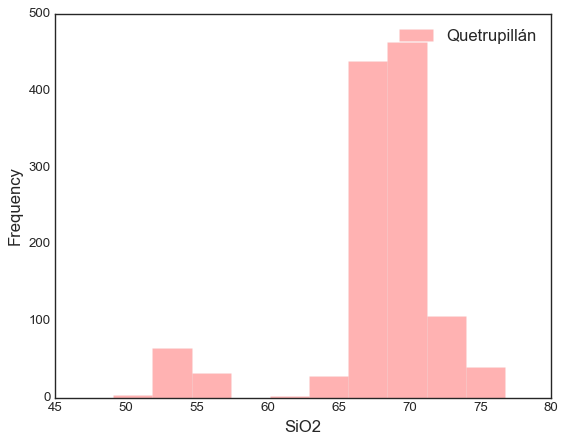

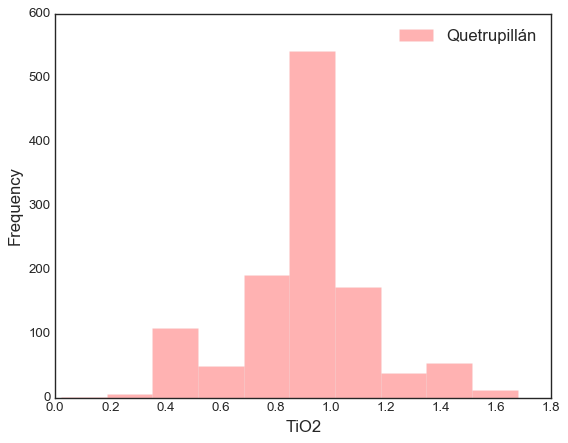

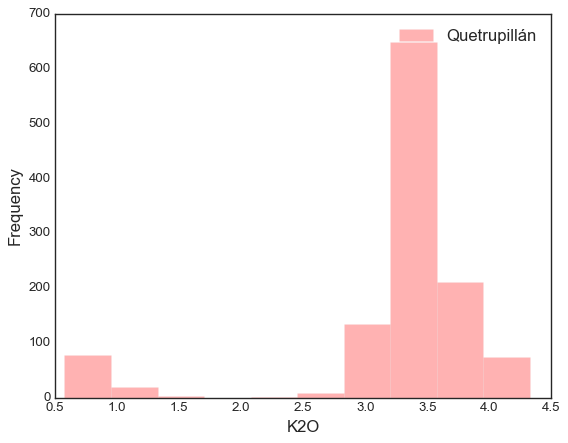

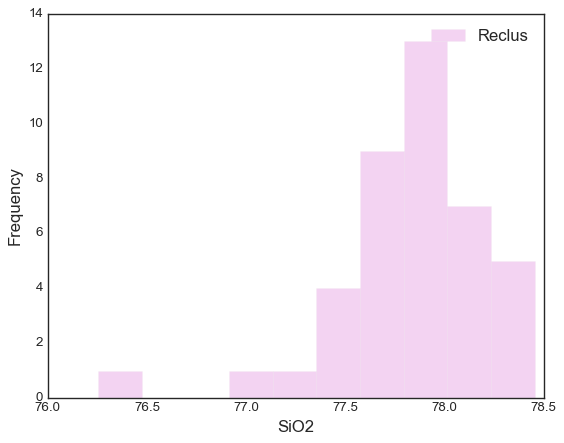

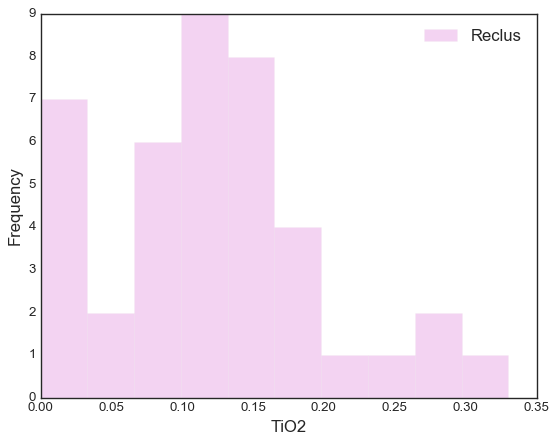

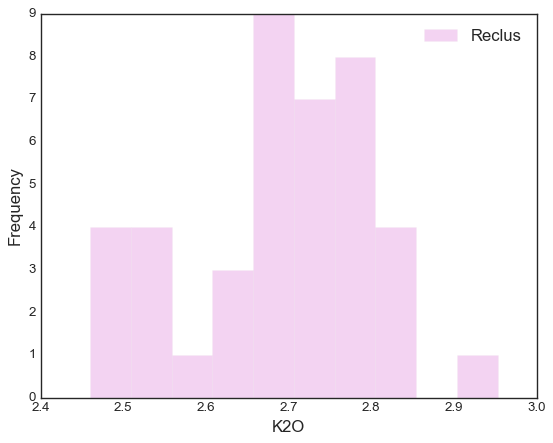

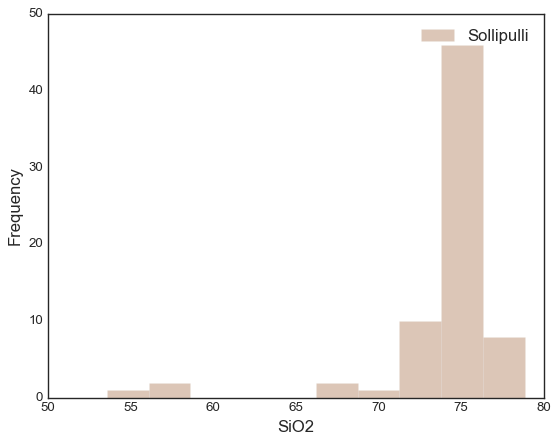

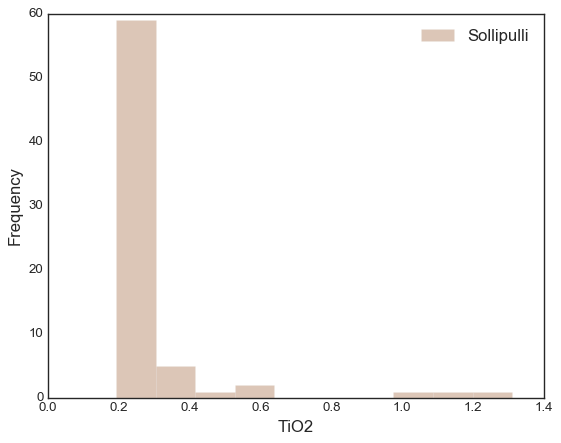

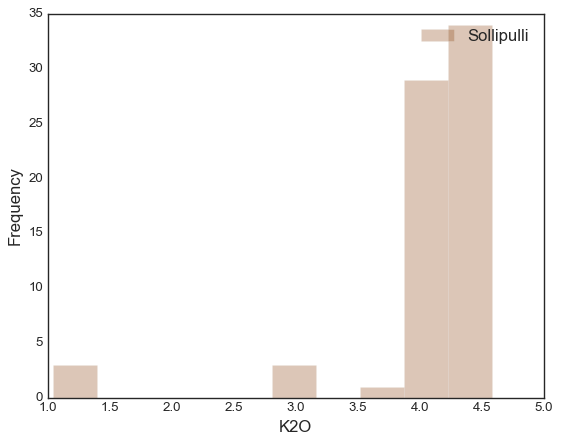

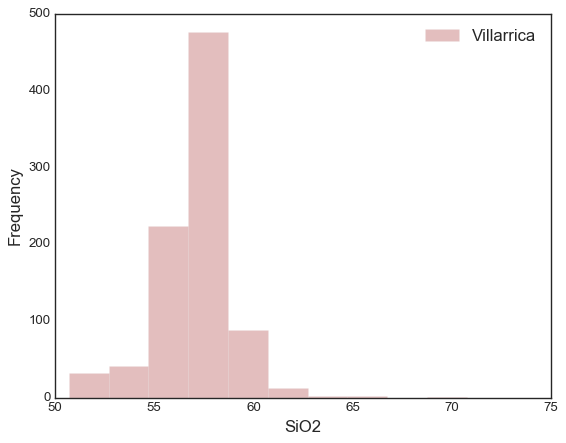

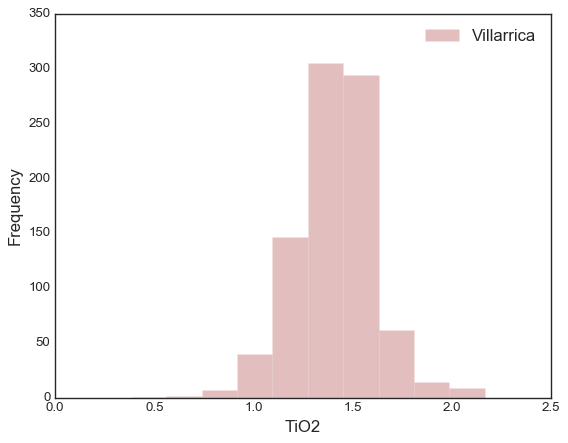

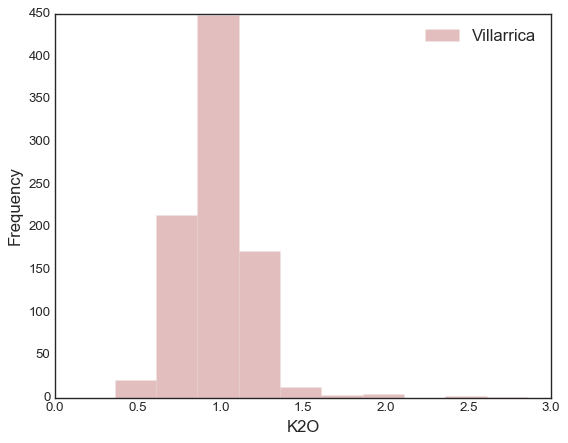

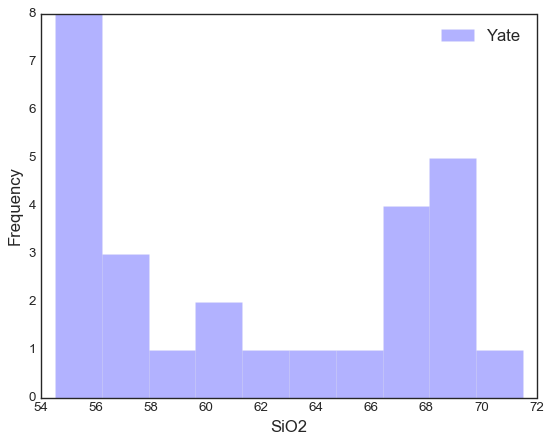

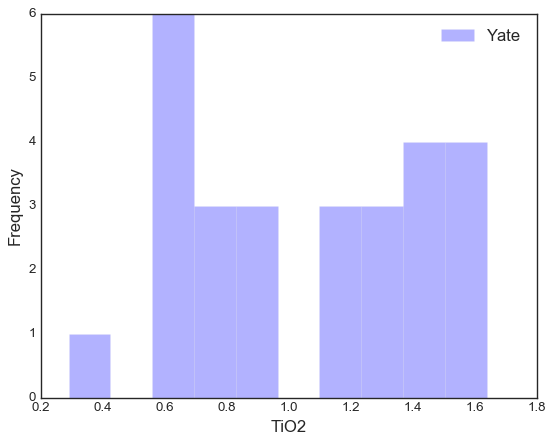

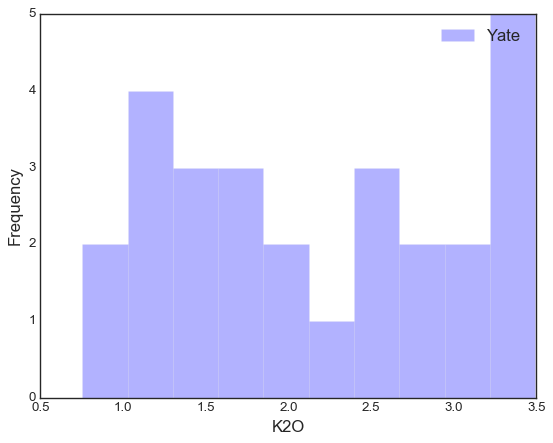

In [89]:
DatA = Data
volcanes = DatA['Volcán'].unique()

for volcan in volcanes:
    Data_volcan = DatA[DatA['Volcán']==volcan]

    for elemento in DatA.columns :   
        if (elemento != 'Volcán')&(elemento != 'Evento'):   
            coloR, Marker  = simbologia(volcan,'Unknown')
            if pd.isnull(Data_volcan[elemento]).all():
                print('Volcán {} without information for {}'.format(i,elemento))   
            else:
                plt.hist(Data_volcan[elemento] ,label= volcan, color = coloR, alpha= 0.3,range=(np.nanmin(Data_volcan[elemento]), np.nanmax(Data_volcan[elemento])))  
                plt.xlabel(elemento, fontsize=15)
                plt.ylabel('Frequency', fontsize=15)
                plt.legend(bbox_to_anchor=(1,1),ncol=2, fontsize=15)
                plt.show()

### Train/test sets

In [90]:
from sklearn.model_selection import train_test_split

In [91]:
#Para generar los modelos tiene que dividirse la info en trin y test sets, los que tienen que tener añadido además la label
Volcanes = Data['Volcán']
Samples = Data.drop(['Volcán'], axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(Samples,Volcanes,test_size=0.25,random_state=42)

## Nearest neighbour

Supervised, classifier, radius_neighbors

In [92]:
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score
from sklearn.neighbors import NearestNeighbors,RadiusNeighborsClassifier

In [107]:
neigh = RadiusNeighborsClassifier(algorithm='kd_tree',outlier_label='Unknown',weights='distance')
neigh.fit(X_train,Y_train)
predictions = neigh.predict(X_test)

In [108]:
print(recall_score(Y_test, predictions,average = "micro"))
print(precision_score(Y_test, predictions,average = "micro"))

0.6516245487364621
0.6516245487364621


In [82]:
def visual_score(AA,BB,X_train,Y_train,X_test,Y_test,prediction,Xmin='default',Xmax='default',Ymin='default',Ymax='default',save=False):
    
    plt.figure(figsize=(13,13))
    ax = plt.axes()
    
#-------------------------- Train set ---------------------------------------
    X_train['Volcán'] = Y_train
    X_train = X_train.sort_values(by=['Volcán'])
    X_train = X_train.reset_index(drop=True)
    A = X_train[AA].values
    B = X_train[BB].values
    Evento = 0
    Volcán = 0
    Volcanes = X_train['Volcán']    
    
    for i in range(0,np.size(Volcanes)):
        #print("1 Volcán {}".format(Volcanes[i]))
        if Volcanes[i] == Volcán:
            Color, Marker  = simbologia(Volcanes[i],'Unknown')
            plt.plot(A[i],B[i], color = Color, marker = Marker,markersize=12, alpha=0.2,markeredgecolor = 'black')
        else:
            Color, Marker  = simbologia(Volcanes[i],'Unknown')
            plt.plot(A[i],B[i], color = Color, marker = Marker, markersize = 12,alpha=0.2, label = Volcanes[i], markeredgecolor = 'black')
            Volcán = Volcanes[i]
                           
#-------------------------- Test set ---------------------------------------
    X_test['Volcán'] = Y_test
    X_test = X_test.sort_values(by=['Volcán'])
    X_test = X_test.reset_index(drop=True)
    A = X_test[AA].values
    B = X_test[BB].values
    Evento = 0
    Volcán = 0
    Volcanes = X_test['Volcán']
 
    
    
    for i in range(0,np.size(Volcanes)):
        if Volcanes[i] == prediction[i]:
            #print("1 Volcán {}, Core {} ".format(Volcanes[i],Eventos[i]))
            Color, Marker  = simbologia(Volcanes[i],'Unknown')
            plt.plot(A[i],B[i], color = Color, marker = Marker,markersize=12, alpha=1,markeredgecolor = 'black')        
        else:
            #print("2 Volcán {}, predicción {}".format(Volcanes[i],predictions[i]))
            Color, Marker  = simbologia(predictions[i],'Unknown')
            plt.plot(A[i],B[i], color = Color, marker = '*',markersize=12, alpha=0.5,markeredgecolor = 'black')               
        
    if (Xmax!='default')&(Xmin!='default'):
        plt.xlim(Xmin,Xmax)

    if (Ymin!='default')&(Ymax!='default'):
        plt.ylim(Ymin,Ymax)		
		

    plt.xlabel(AA, fontsize = 22)
    plt.ylabel(BB, fontsize = 22)
    ax.tick_params(labelsize = 21)
    leg=plt.legend(loc='upper right', fancybox=True, bbox_to_anchor=(1.5,1),ncol=2,fontsize=11)
    leg.get_frame().set_alpha(1)
    
    if save:
        path = os.getcwd()
        plt.savefig(path+'../Plots/'+AA+'vs'+BB+' '+'.pdf',dpi = 300,bbox_extra_artists=(leg,),bbox_inches='tight')
    
    plt.show()

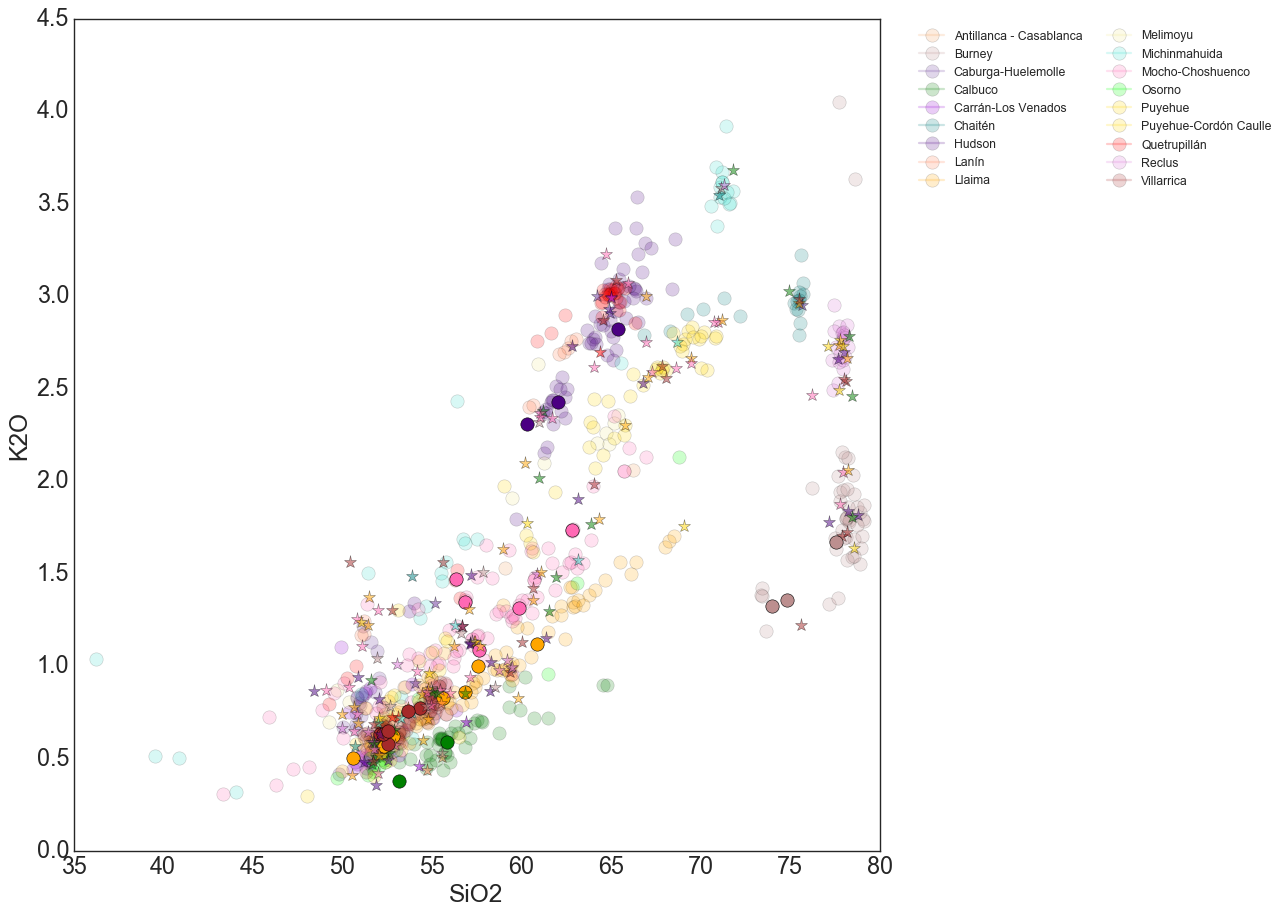

In [83]:
plt.style.use('seaborn-white')
visual_score('SiO2','K2O',X_train,Y_train,X_test,Y_test,predictions)

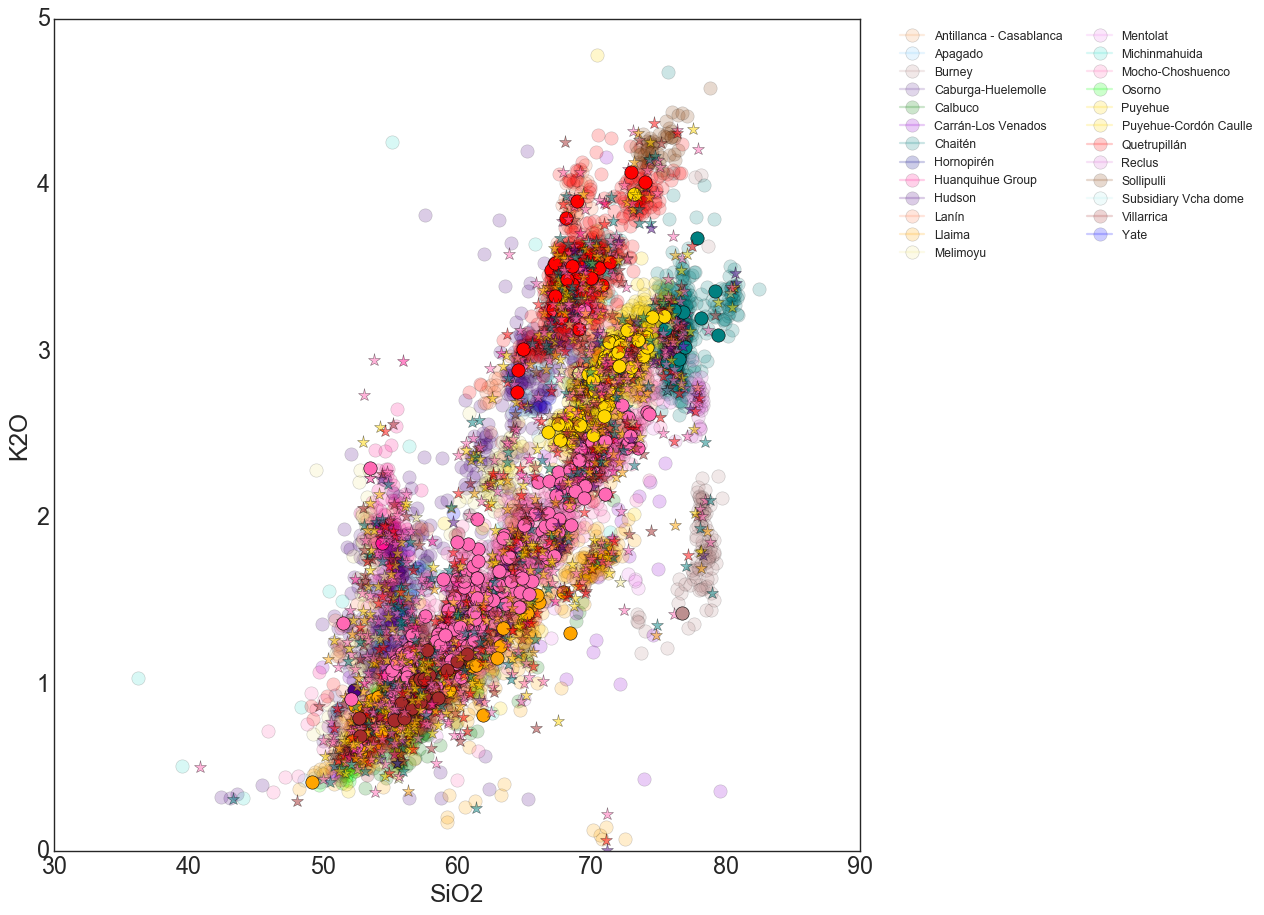

In [109]:
plt.style.use('seaborn-white')
visual_score('SiO2','K2O',X_train,Y_train,X_test,Y_test,predictions)